In [1]:
import pandas as pd
import numpy as np

import re
import string

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")

from nlppreprocess import NLP
import nltk
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB, CategoricalNB,GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Fortune\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load Data

In [2]:
#Load the train set 
train_df = pd.read_csv('https://raw.githubusercontent.com/FortuneM118/South-African-Language-Identification-Hack-Data/main/train_set.csv')

#Load the test set
test_df = pd.read_csv('https://raw.githubusercontent.com/FortuneM118/South-African-Language-Identification-Hack-Data/main/test_set.csv')

# Exploratory Data Analysis (EDA)

In [3]:
#View the first 5 records in the train dataset
train_df.head()

lang_id                                               text
0     xho  umgaqo-siseko wenza amalungiselelo kumaziko ax...
1     xho  i-dha iya kuba nobulumko bokubeka umsebenzi na...
2     eng  the province of kwazulu-natal department of tr...
3     nso  o netefatša gore o ba file dilo ka moka tše le...
4     ven  khomishini ya ndinganyiso ya mbeu yo ewa maana...

In [4]:
# Overview of the dataframe(elements, size, dtype and nulls)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB


In [5]:
# Get list of unique lanuage IDs
type_labels = list(train_df.lang_id.unique())
print(type_labels)

['xho', 'eng', 'nso', 'ven', 'tsn', 'nbl', 'zul', 'ssw', 'tso', 'sot', 'afr']


In [6]:
# Get count of values in each class (All classes are balanced)
train_df["lang_id"].value_counts()

xho    3000
eng    3000
nso    3000
ven    3000
tsn    3000
nbl    3000
zul    3000
ssw    3000
tso    3000
sot    3000
afr    3000
Name: lang_id, dtype: int64

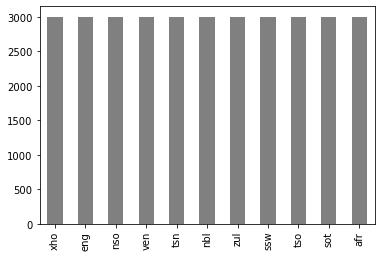

In [7]:
# Get count of values in each class (All classes are balanced) --Visual
train_df['lang_id'].value_counts().plot(kind = 'bar', stacked=True, color='gray')
plt.show()

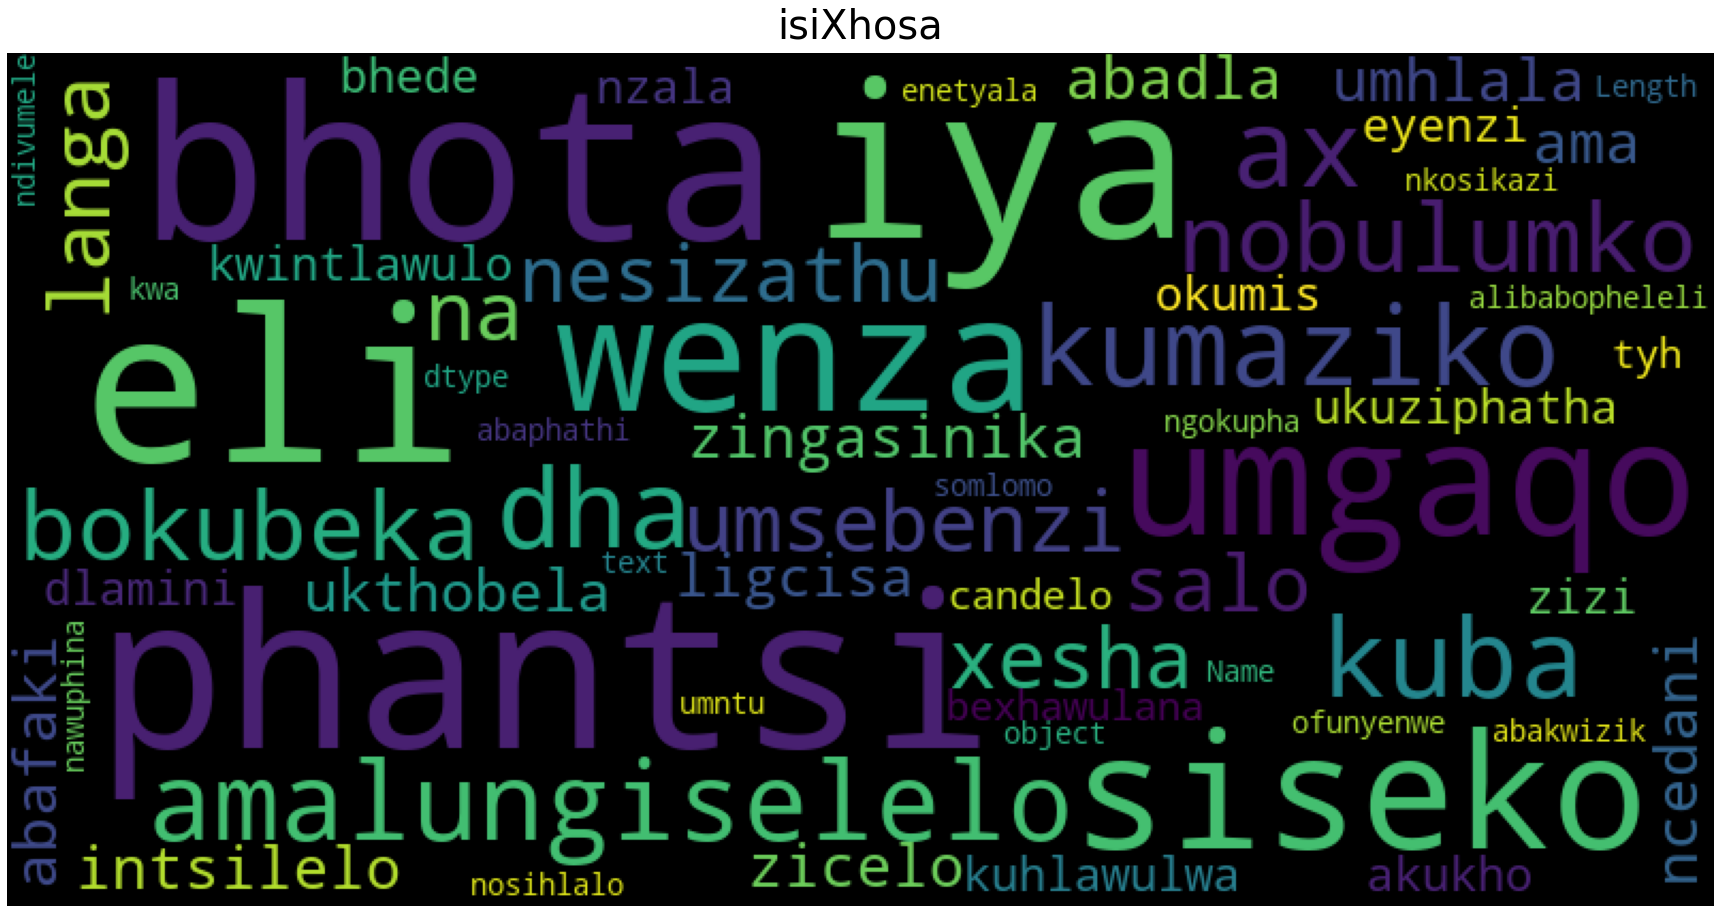

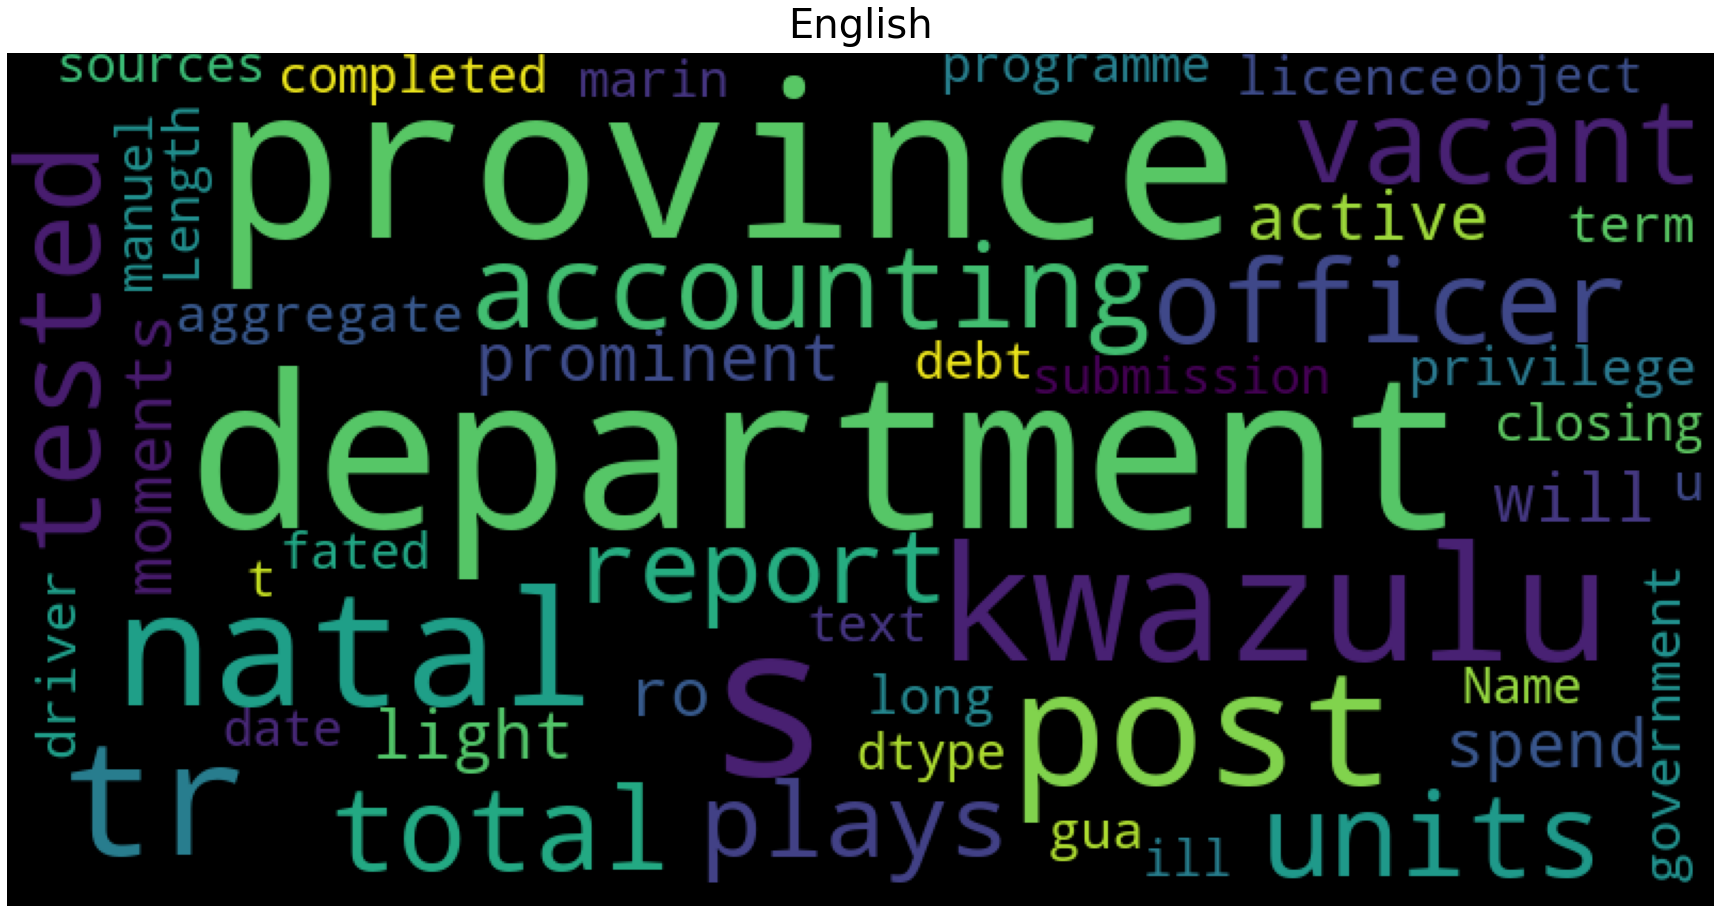

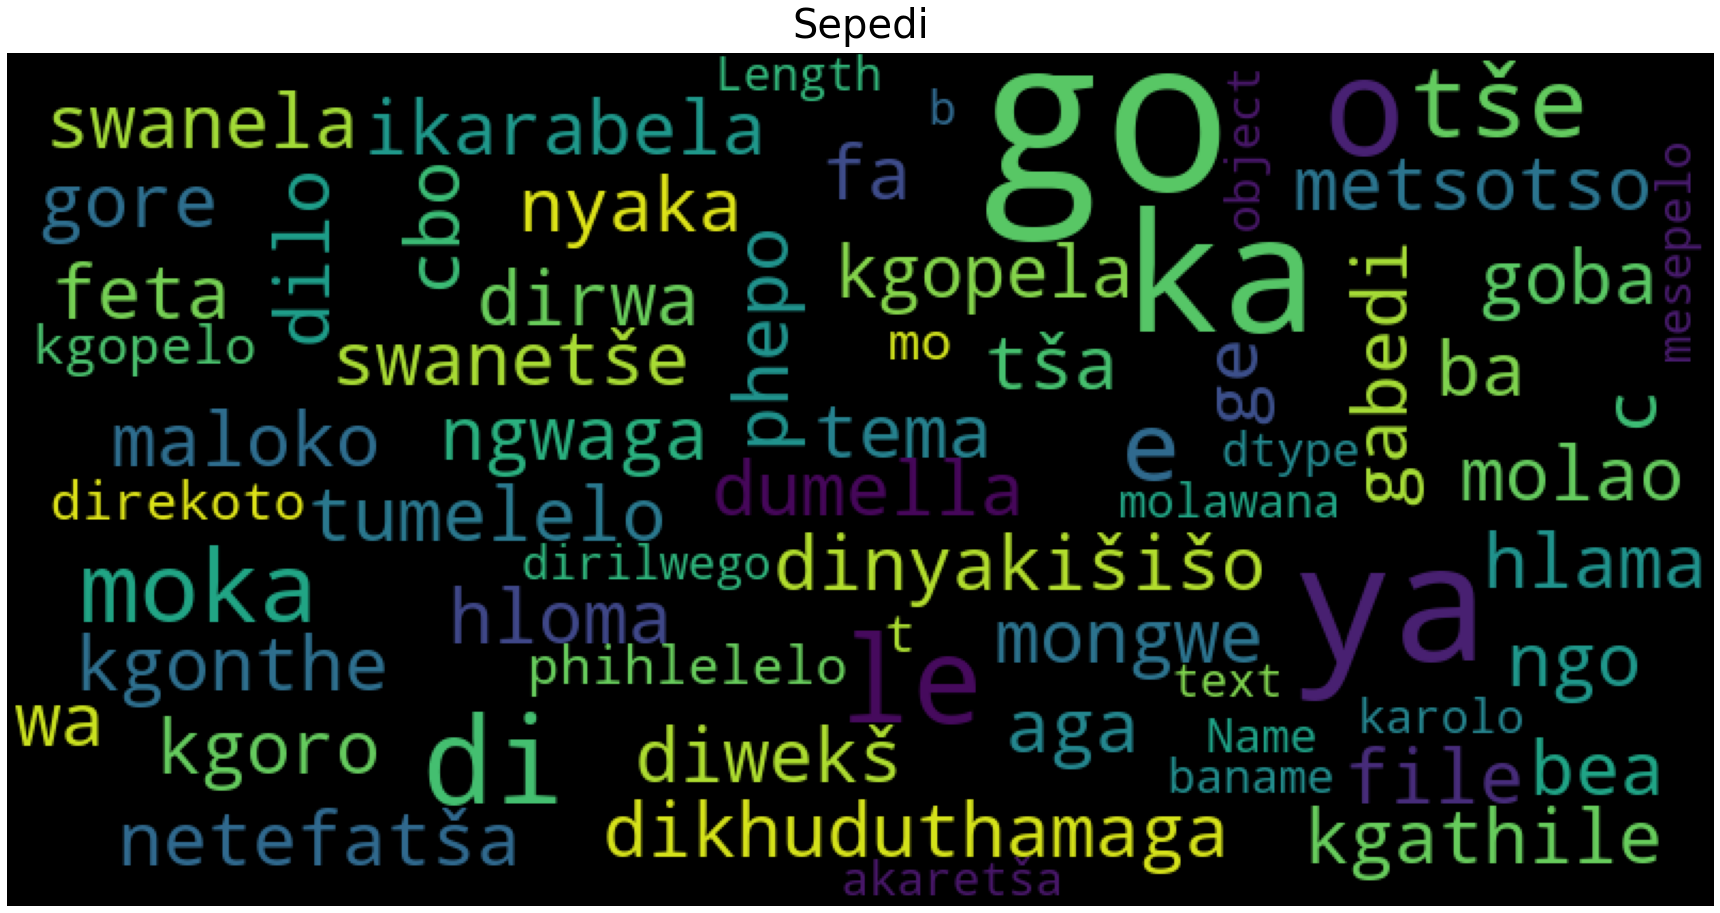

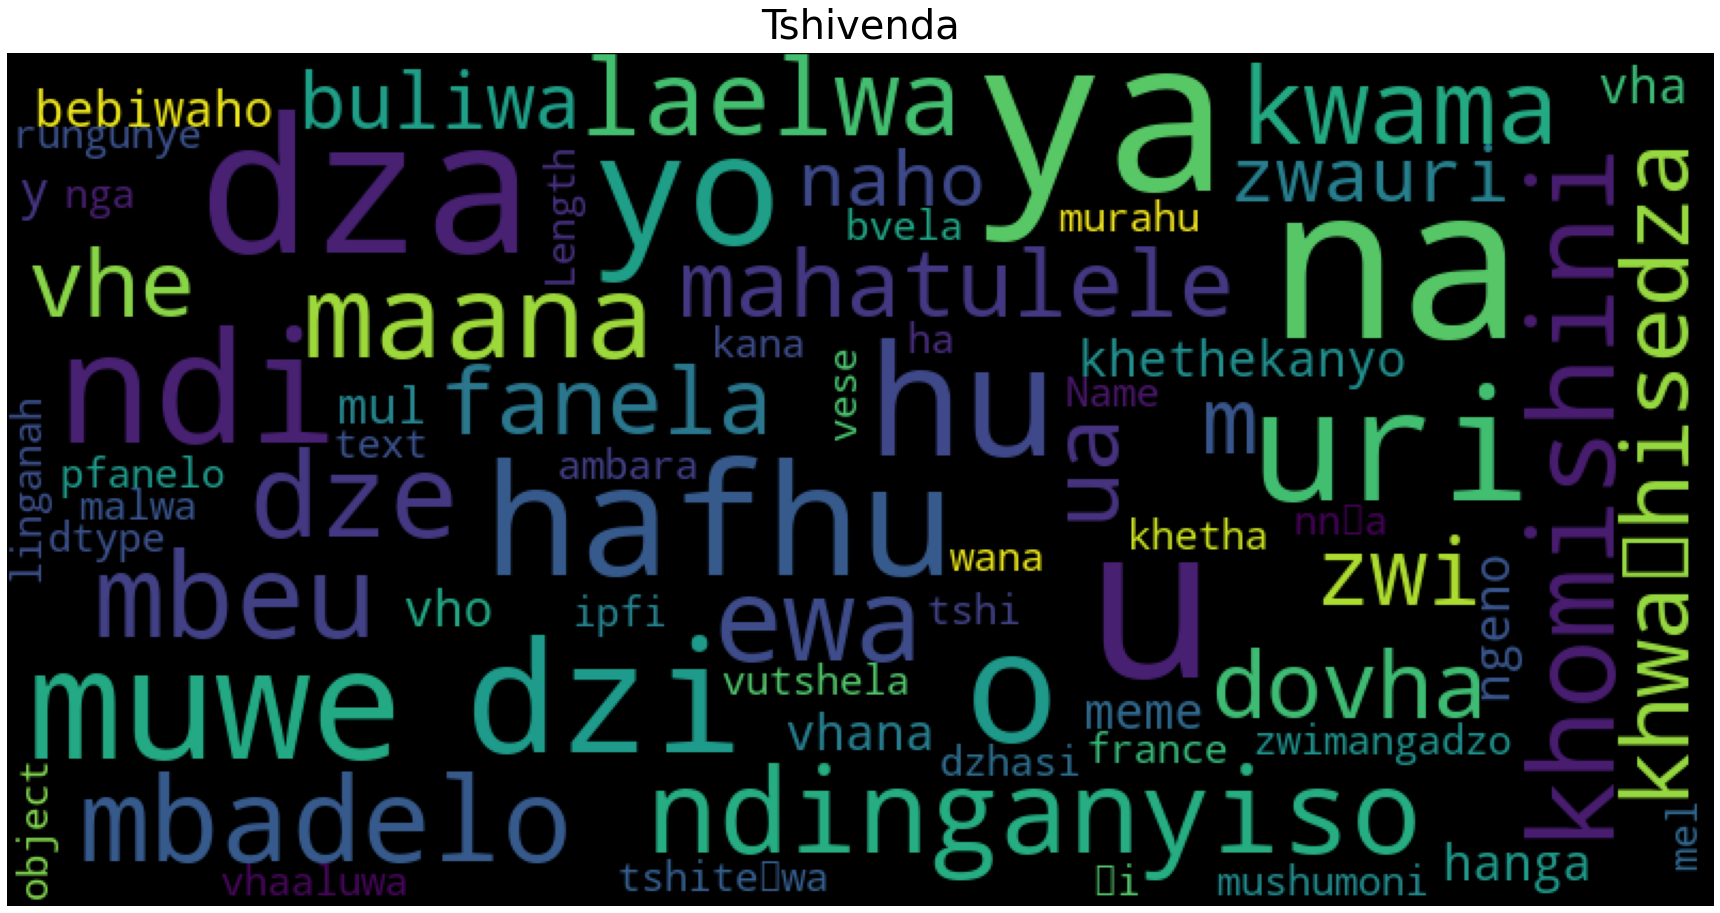

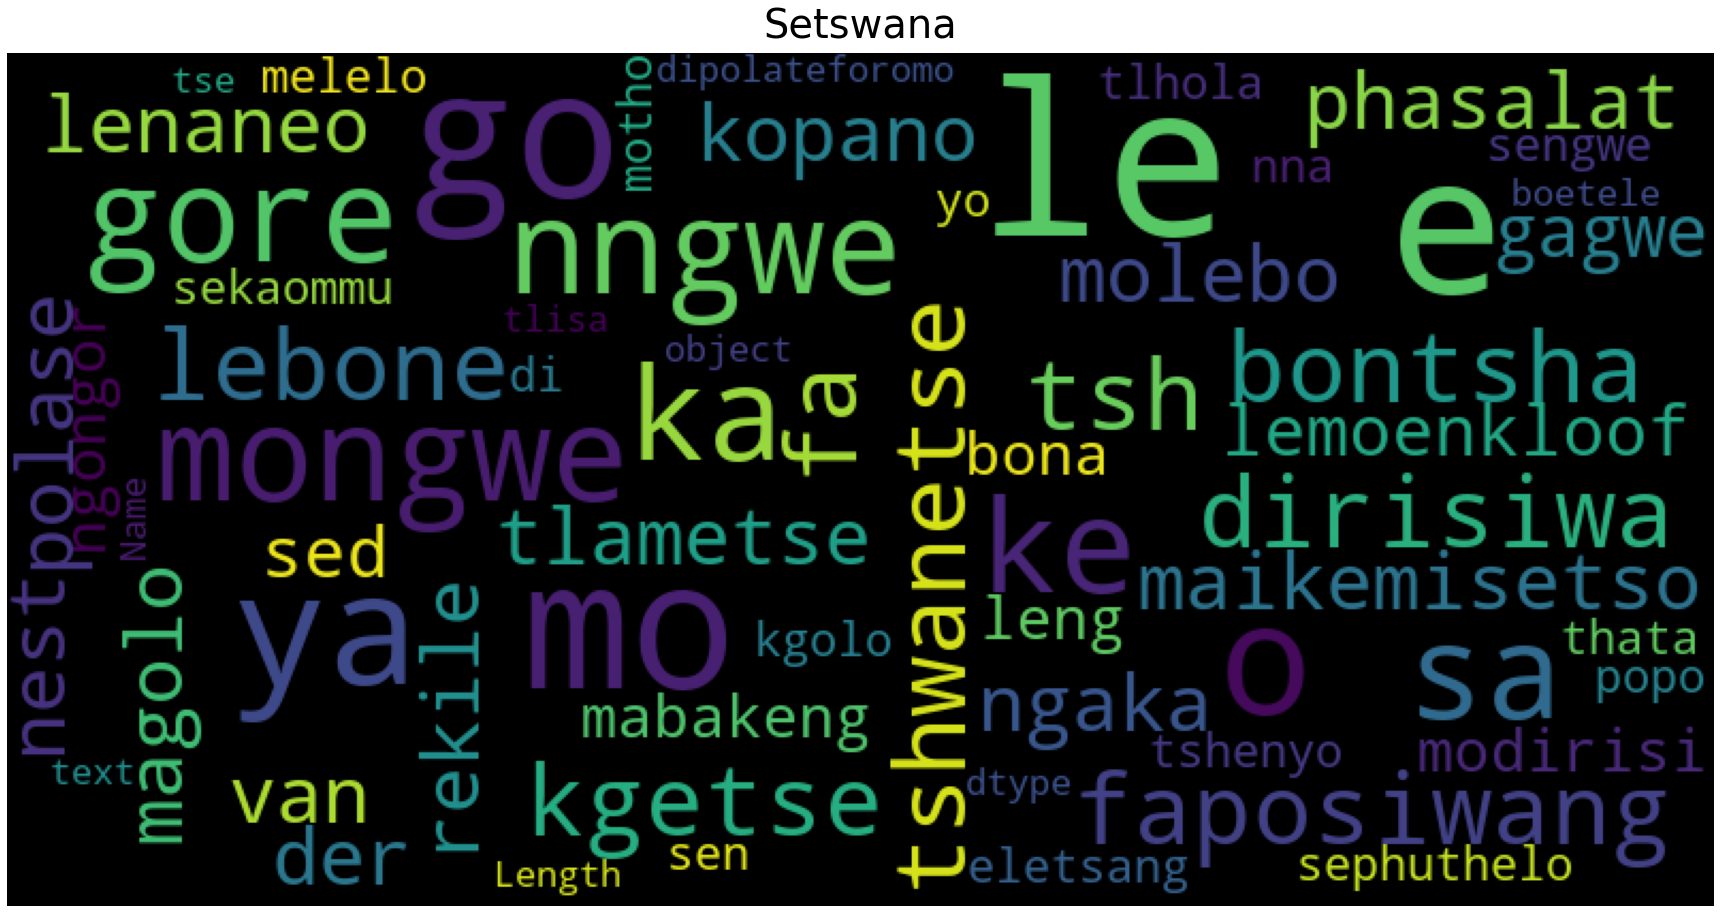

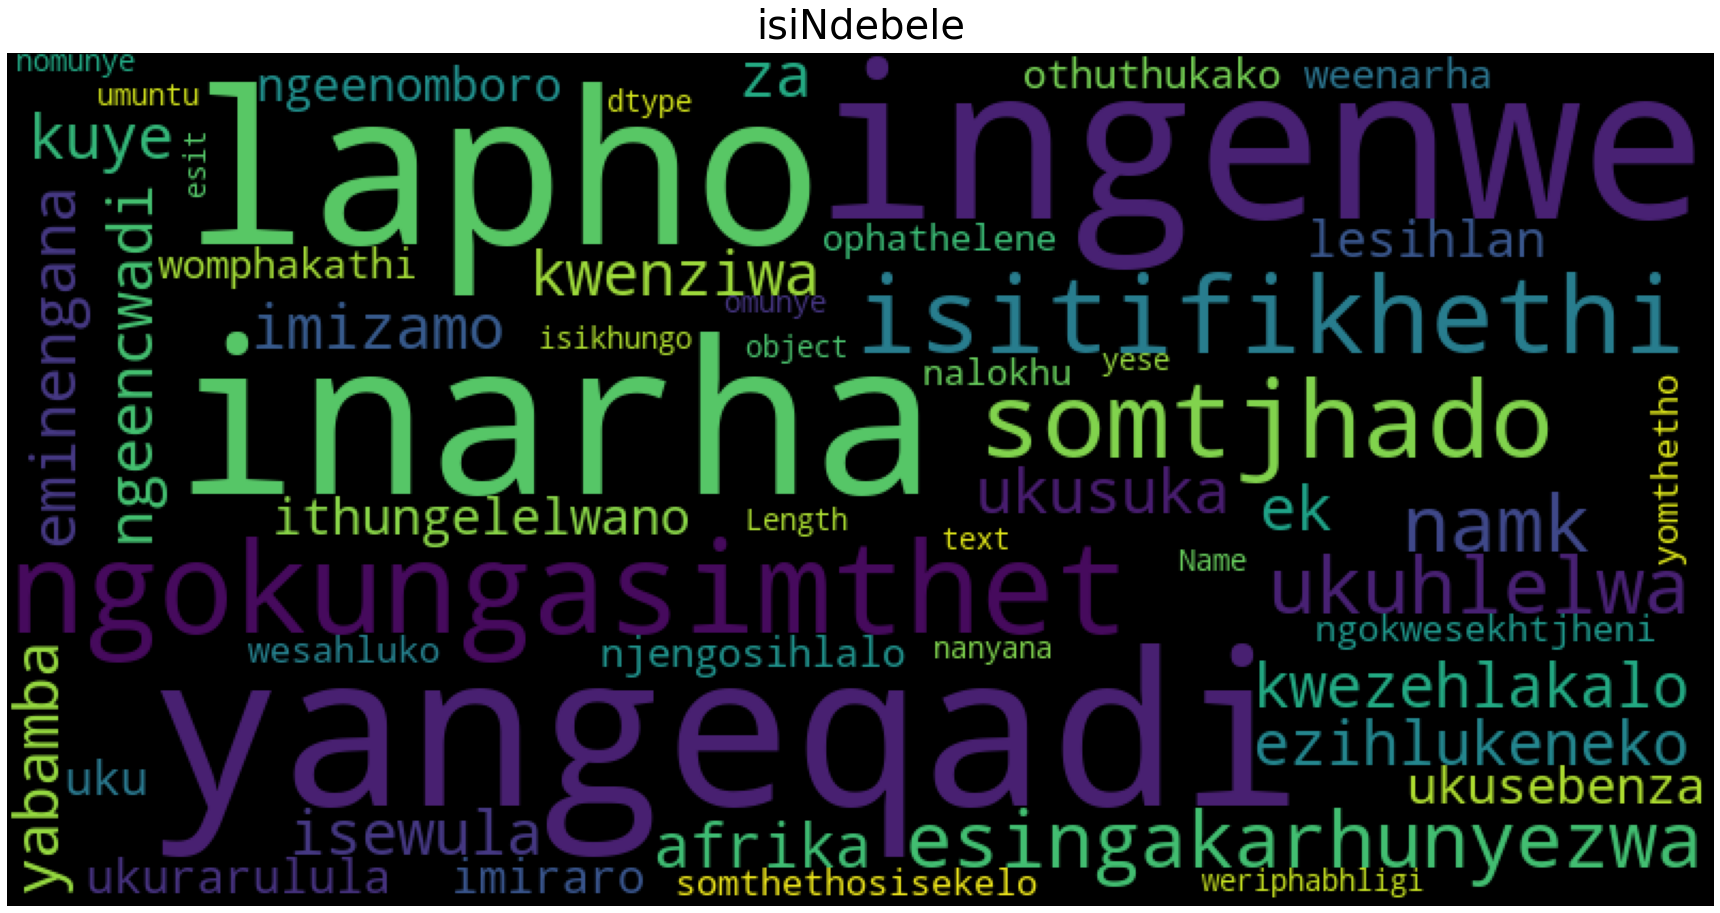

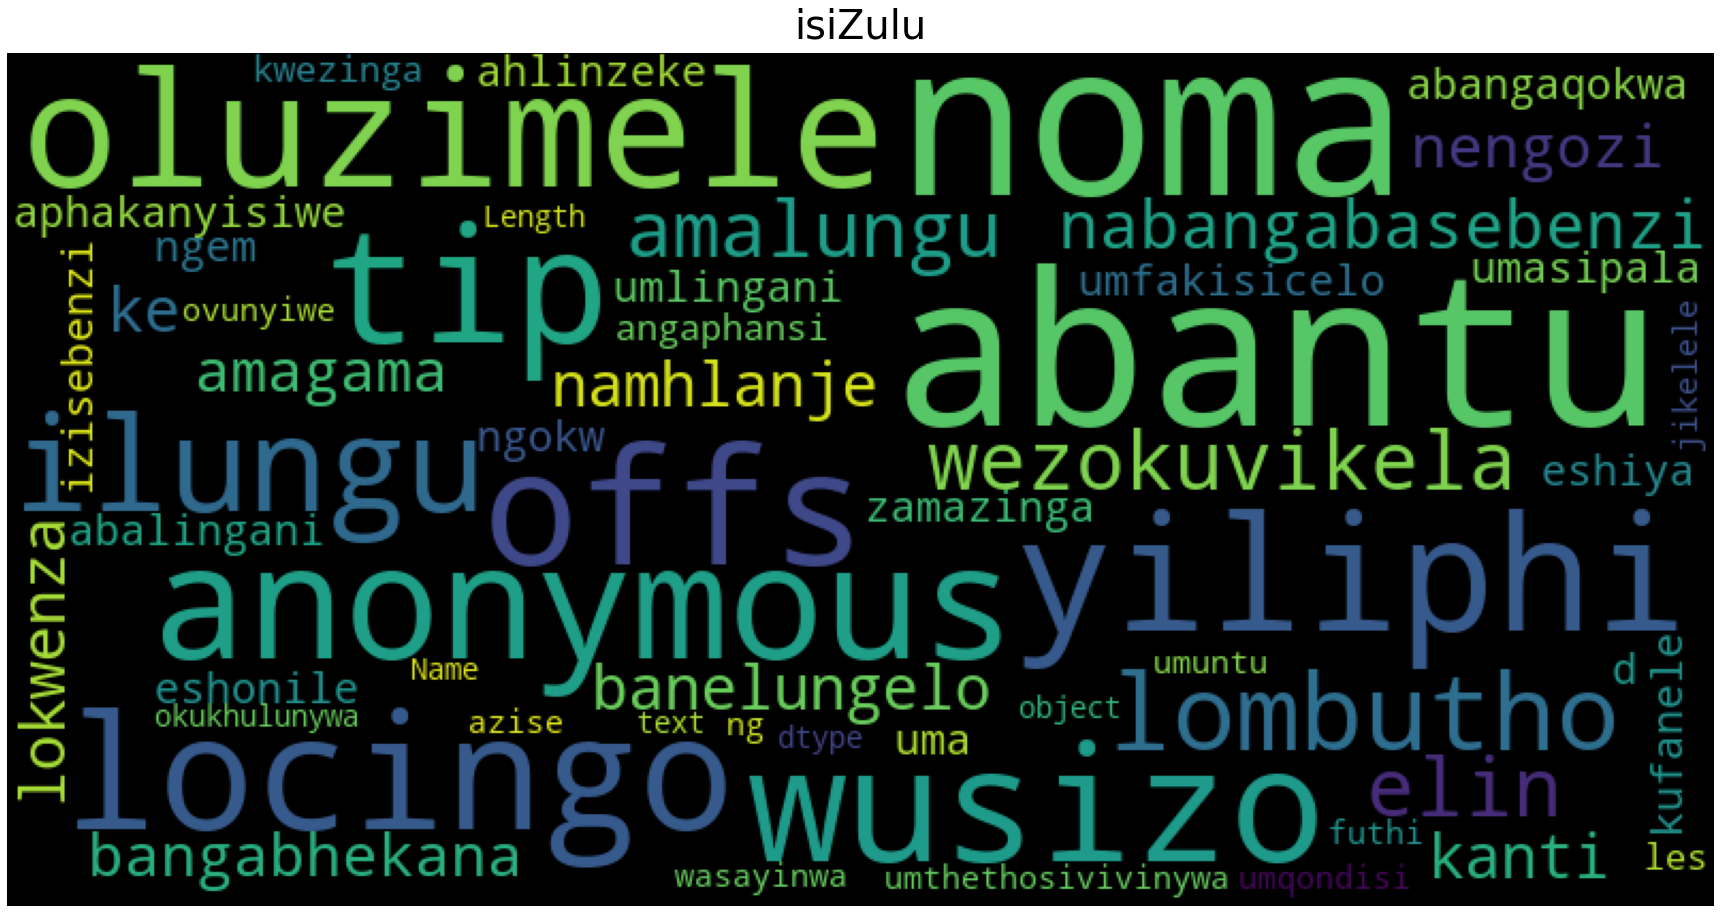

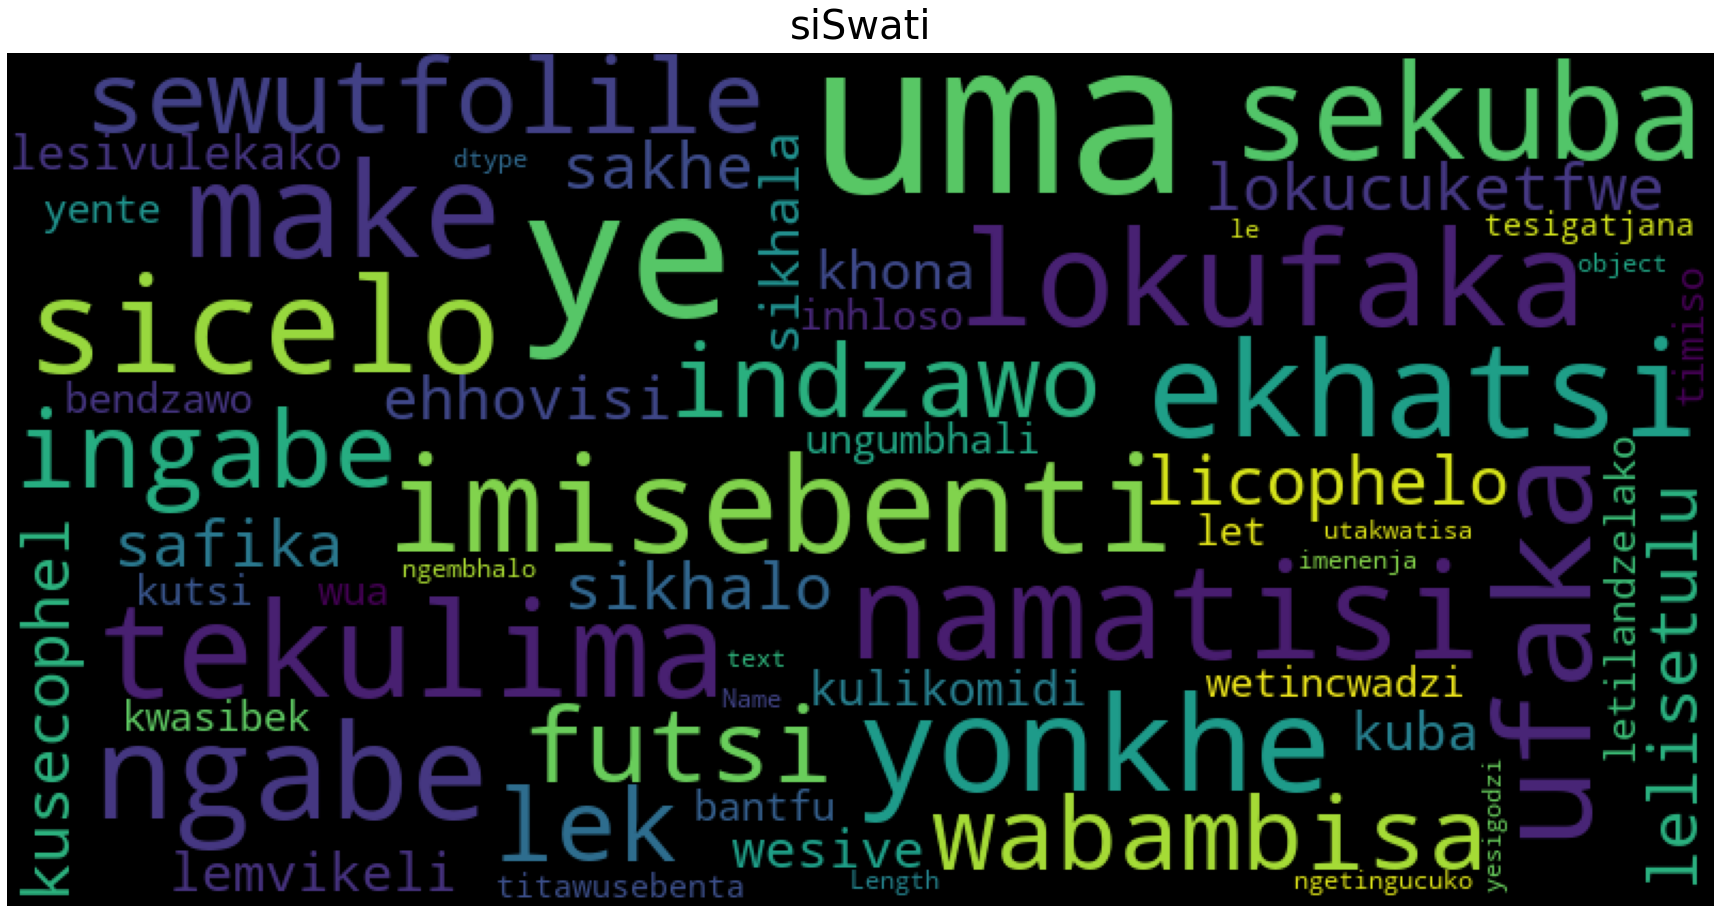

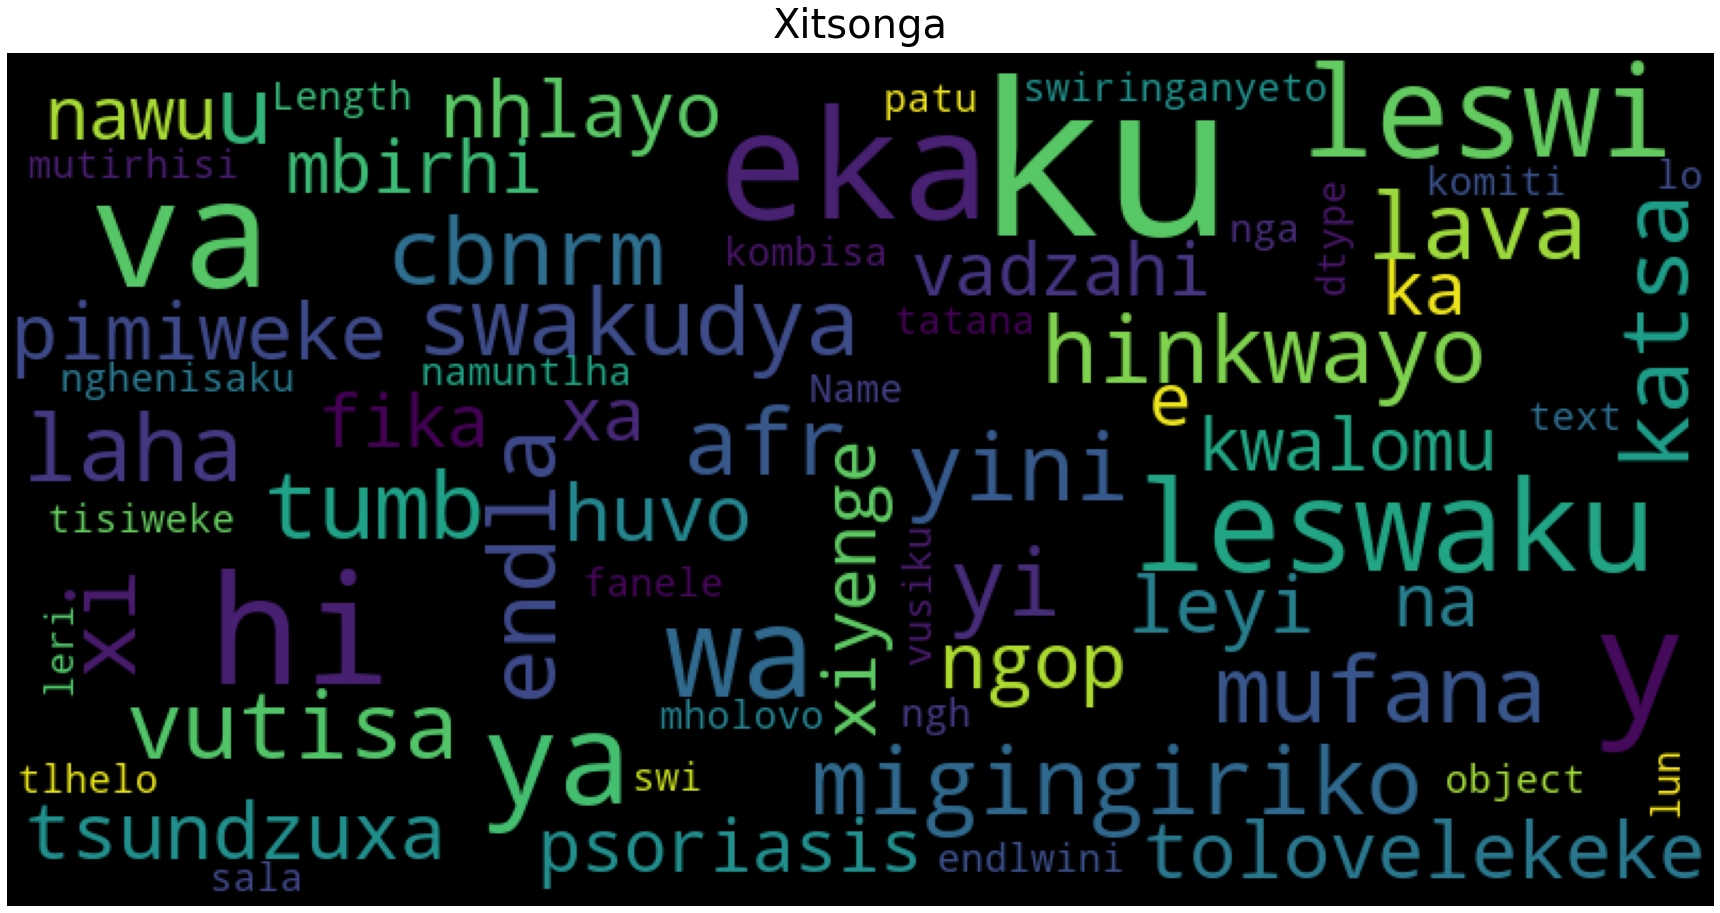

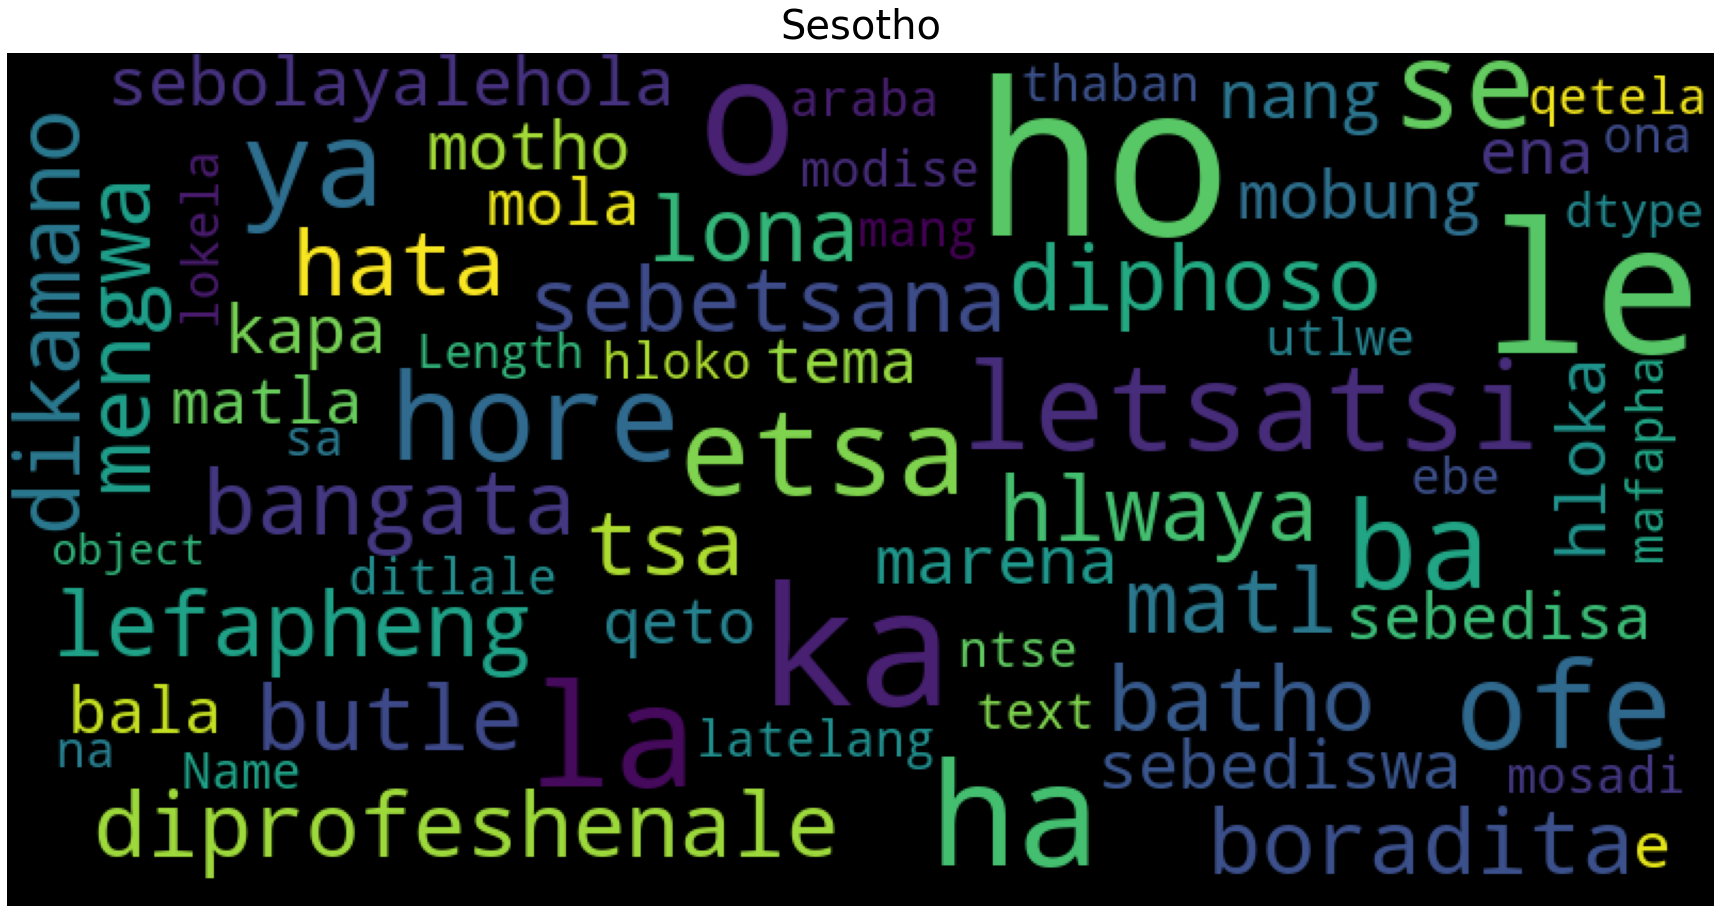

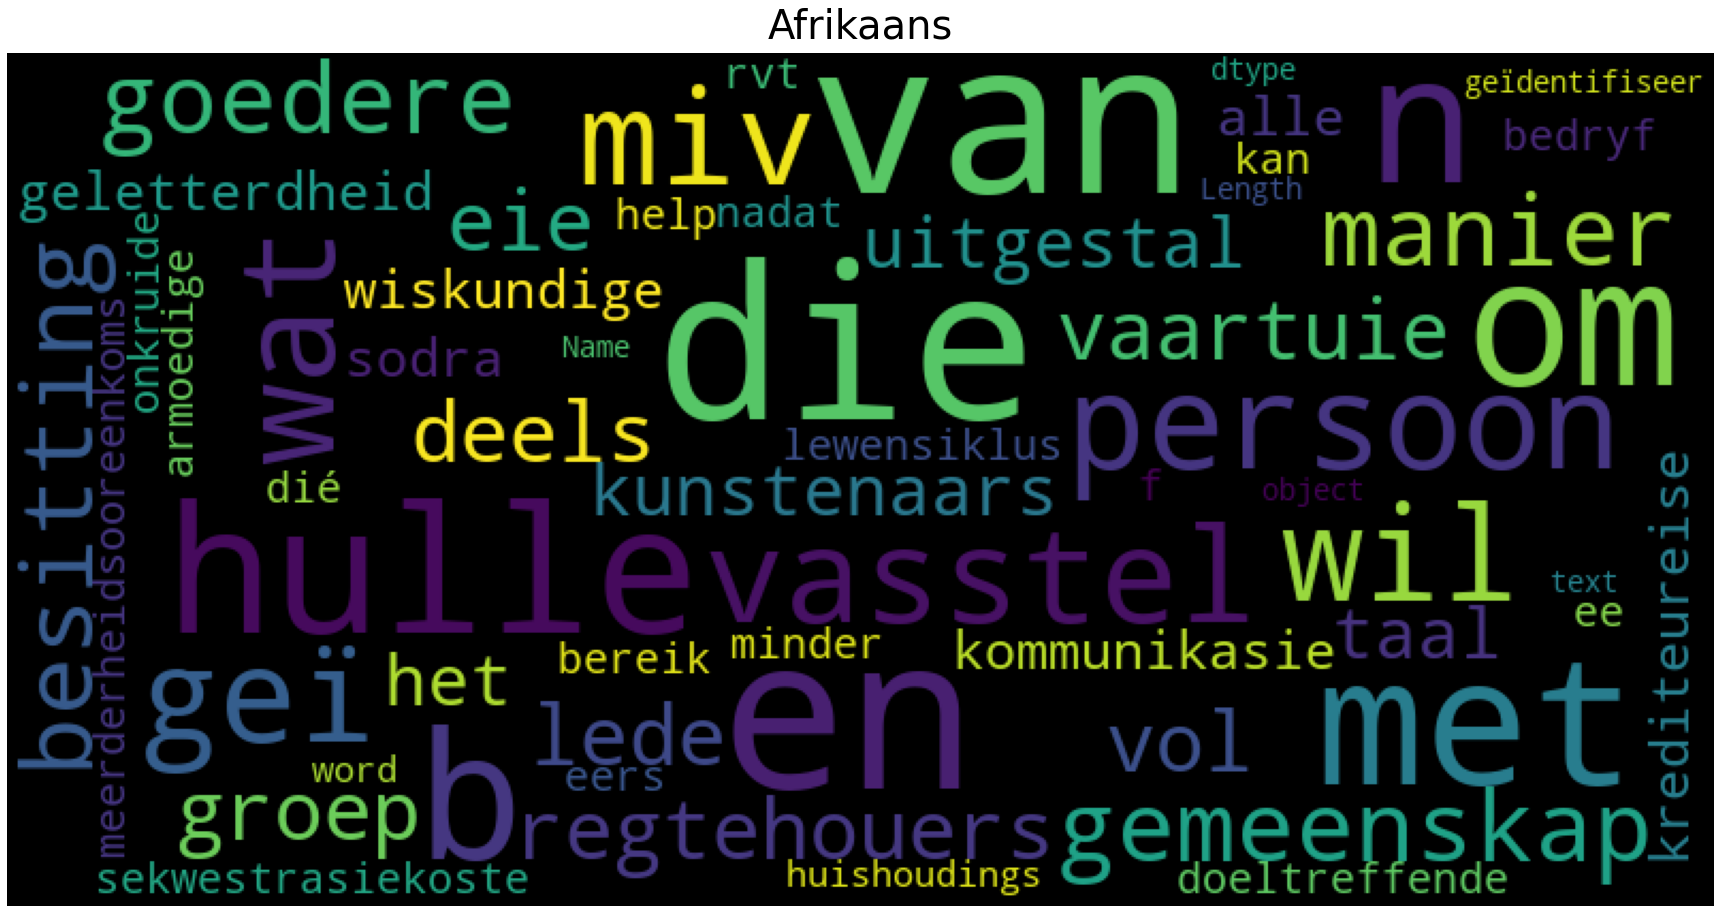

In [8]:
from wordcloud import WordCloud, STOPWORDS
# Remove test with stopwords 
# Defining the wordcloud function
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False): 
    # Creating a set of stopwords to ignore
    stopwords = set(STOPWORDS)
    # Setting the parameters for your wordcloud
    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size) # Creating the figure
    if image_color:                
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud([train_df.loc[train_df.lang_id =='xho']['text']], title="isiXhosa")
plot_wordcloud([train_df.loc[train_df.lang_id =='eng']['text']], title="English")
plot_wordcloud([train_df.loc[train_df.lang_id =='nso']['text']], title="Sepedi")
plot_wordcloud([train_df.loc[train_df.lang_id =='ven']['text']], title="Tshivenda")
plot_wordcloud([train_df.loc[train_df.lang_id =='tsn']['text']], title="Setswana")
plot_wordcloud([train_df.loc[train_df.lang_id =='nbl']['text']], title="isiNdebele")
plot_wordcloud([train_df.loc[train_df.lang_id =='zul']['text']], title="isiZulu")
plot_wordcloud([train_df.loc[train_df.lang_id =='ssw']['text']], title="siSwati")
plot_wordcloud([train_df.loc[train_df.lang_id =='tso']['text']], title="Xitsonga")
plot_wordcloud([train_df.loc[train_df.lang_id =='sot']['text']], title="Sesotho")
plot_wordcloud([train_df.loc[train_df.lang_id =='afr']['text']], title="Afrikaans")

In [9]:
## Number of words in the text
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text
train_df["num_unique_words"] = train_df["text"].apply(lambda x: len(set(str(x).split())))
test_df["num_unique_words"] = test_df["text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text
train_df["num_chars"] = train_df["text"].apply(lambda x: len(str(x)))
test_df["num_chars"] = test_df["text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text
train_df["num_stopwords"] = train_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test_df["num_stopwords"] = test_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

## Number of punctuations in the text
train_df["num_punctuations"] =train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_df["num_punctuations"] =test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text
train_df["num_words_upper"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["num_words_upper"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text
train_df["num_words_title"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["num_words_title"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text 
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [10]:
#View word class stats dataframe
words_per_class = train_df.groupby('lang_id').sum()
words_per_class

num_words  num_unique_words  num_chars  num_stopwords  \
lang_id                                                          
afr         117856             90933     737779           8412   
eng         120700             91518     737502          55407   
nbl          77238             72252     734140            202   
nso         135758             94821     726051           4858   
sot         137202             97368     739891           4002   
ssw          78957             73953     734389            218   
tsn         134791             94097     737294           4296   
tso         128327             95818     734193           3980   
ven         132784             97169     736523           5836   
xho          81880             76789     735547            279   
zul          79787             74743     728640            438   

         num_punctuations  num_words_upper  num_words_title  mean_word_len  
lang_id                                                                     
afr                  2079                0                0   16172.151051  
eng                  1025                0                0   15596.129622  
nbl                  2167                0                0   25833.124684  
nso                   413                0                0   13242.001179  
sot                   339                0                0   13367.163826  
ssw                  1696                0                0   25263.450258  
tsn                   714                0                0   13599.372683  
tso                   792                0                0   14340.291513  
ven                   532                0                0   13812.214860  
xho                  2441                0                0   24312.747485  
zul                  1638                0                0   24742.618846

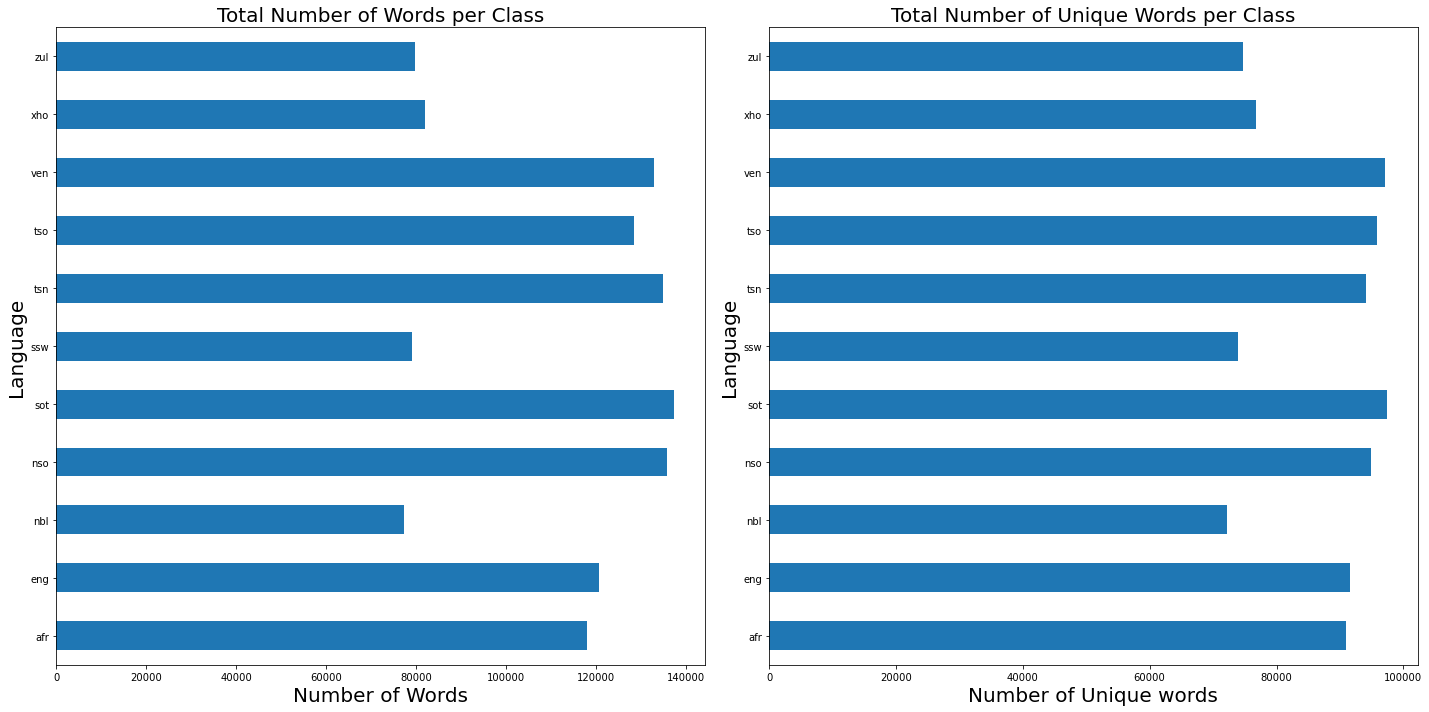

In [11]:
plt.subplot(1, 2, 1)
words_per_class['num_words'].plot(kind='barh',figsize = (20,10))
plt.xlabel('Number of Words', size = 20)
plt.ylabel('Language', size = 20)
plt.title('Total Number of Words per Class', fontsize = 20)

plt.subplot(1, 2, 2)
words_per_class['num_unique_words'].plot(kind='barh',figsize = (20,10))
plt.xlabel('Number of Unique words', size = 20)
plt.ylabel('Language', size = 20)
plt.title('Total Number of Unique Words per Class', fontsize = 20)


plt.tight_layout()

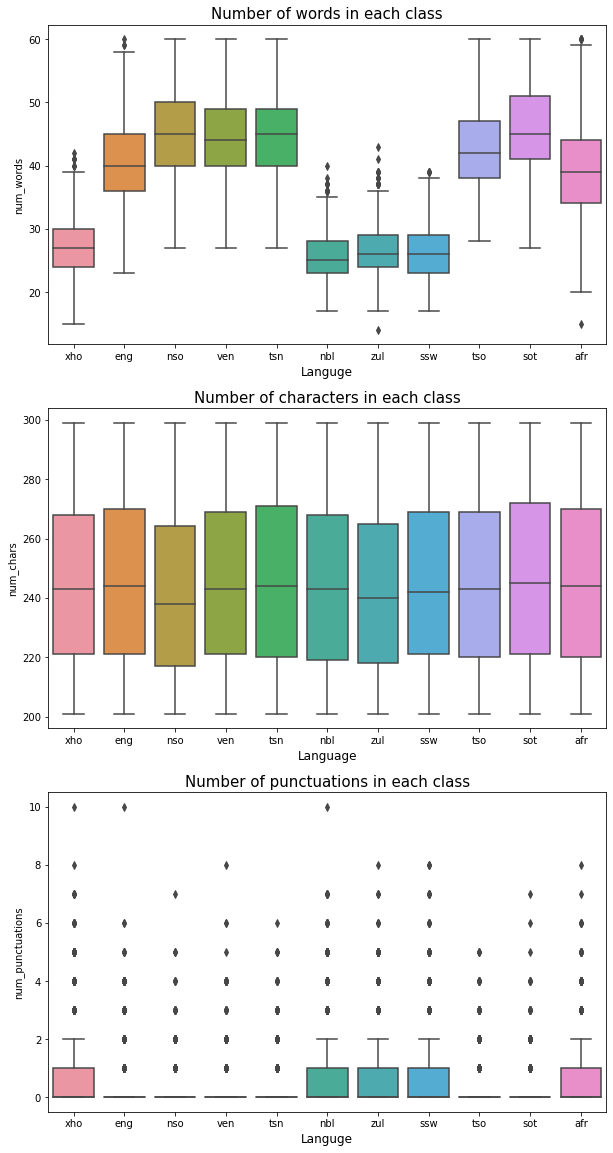

In [14]:
train_df['num_words'].loc[train_df['num_words']>60] = 60 #truncation for better visuals
train_df['num_punctuations'].loc[train_df['num_punctuations']>10] = 10 #truncation for better visuals
train_df['num_chars'].loc[train_df['num_chars']>350] = 350 #truncation for better visuals

f, axes = plt.subplots(3, 1, figsize=(10,20))
sns.boxplot(x='lang_id', y='num_words', data=train_df, ax=axes[0])
axes[0].set_xlabel('Languge', fontsize=12)
axes[0].set_title("Number of words in each class", fontsize=15)

sns.boxplot(x='lang_id', y='num_chars', data=train_df, ax=axes[1])
axes[1].set_xlabel('Language', fontsize=12)
axes[1].set_title("Number of characters in each class", fontsize=15)

sns.boxplot(x='lang_id', y='num_punctuations', data=train_df, ax=axes[2])
axes[2].set_xlabel('Languge', fontsize=12)
axes[2].set_title("Number of punctuations in each class", fontsize=15)
plt.show()

# Preprocessing

In [15]:
#Remove punctuation (This reduces Kaggle score) words text,Name and dtype are found in all languages.

"""def remove_special_characters(text):
    text= re.sub(r'[-]',' ',text)
    text= re.sub(r'[_]', ' ', text)
    text= re.sub(r'[^\w\s]','',text)
    text= re.sub('[0-9]+', '', text)
    text= re.sub(r'[^\x00-\x7f]',r'', text)
    text = re.sub('text', '', text)
    text = re.sub('Name', '', text)
    text = re.sub('dtype', '', text)
    return text"""

"def remove_special_characters(text):\n    text= re.sub(r'[-]',' ',text)\n    text= re.sub(r'[_]', ' ', text)\n    text= re.sub(r'[^\\w\\s]','',text)\n    text= re.sub('[0-9]+', '', text)\n    text= re.sub(r'[^\x00-\x7f]',r'', text)\n    text = re.sub('text', '', text)\n    text = re.sub('Name', '', text)\n    text = re.sub('dtype', '', text)\n    return text"

In [16]:
# DF to lowecase (text is already in lower)
train_df["text"] = train_df["text"].str.lower()
test_df["text"] = test_df["text"].str.lower()

## Feature selection

In [17]:
#Using only test and language IDs as features
X = train_df["text"] 
y = train_df["lang_id"]
X_t = test_df['text']

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X = cv.fit_transform(X)

In [19]:
X_t = cv.transform(X_t)
X_t.shape

(5682, 141958)

## Train Test Split

In [20]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state=45)

In [21]:
# Import for model eveluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Model building

In [22]:
# Best performer
MNB_model = MultinomialNB(alpha=0.7,fit_prior=False)
MNB_model.fit(x_train, y_train)

MNB_y_pred = MNB_model.predict(x_test)



In [23]:
acccuracy = accuracy_score(y_test, MNB_y_pred)

report = classification_report(y_test,MNB_y_pred)

print("Accuracy is :",acccuracy)
#print("Matrix is :",cm)
print("Report is :",report)

Accuracy is : 1.0
Report is :               precision    recall  f1-score   support

         afr       1.00      1.00      1.00       310
         eng       1.00      1.00      1.00       310
         nbl       1.00      1.00      1.00       299
         nso       1.00      1.00      1.00       317
         sot       1.00      1.00      1.00       308
         ssw       1.00      1.00      1.00       280
         tsn       1.00      1.00      1.00       281
         tso       1.00      1.00      1.00       294
         ven       1.00      1.00      1.00       297
         xho       1.00      1.00      1.00       297
         zul       1.00      1.00      1.00       307

    accuracy                           1.00      3300
   macro avg       1.00      1.00      1.00      3300
weighted avg       1.00      1.00      1.00      3300



In [24]:
ABC_model = AdaBoostClassifier()
ABC_model.fit(x_train, y_train)

ABC_y_pred = ABC_model.predict(x_test)

In [25]:
accuracy = accuracy_score(y_test, ABC_y_pred)
report = classification_report(y_test,ABC_y_pred)

print("Accuracy is :",accuracy)
print("Report is :",report)

Accuracy is : 0.6427272727272727
Report is :               precision    recall  f1-score   support

         afr       1.00      0.97      0.98       310
         eng       0.99      0.98      0.99       310
         nbl       0.32      0.07      0.11       299
         nso       0.63      0.75      0.69       317
         sot       0.92      0.93      0.92       308
         ssw       0.25      0.94      0.39       280
         tsn       0.71      0.43      0.53       281
         tso       1.00      0.91      0.95       294
         ven       0.87      0.94      0.90       297
         xho       0.37      0.13      0.19       297
         zul       0.30      0.01      0.02       307

    accuracy                           0.64      3300
   macro avg       0.67      0.64      0.61      3300
weighted avg       0.67      0.64      0.61      3300



In [26]:
LR_model = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LR_model.fit(x_train, y_train)

LR_y_pred = LR_model.predict(x_test)

In [27]:
accuracy = accuracy_score(y_test, LR_y_pred)

report = classification_report(y_test,LR_y_pred)

print("Accuracy is :",accuracy)
print("Report is :",report)

Accuracy is : 0.9954545454545455
Report is :               precision    recall  f1-score   support

         afr       1.00      1.00      1.00       310
         eng       1.00      1.00      1.00       310
         nbl       0.99      0.98      0.98       299
         nso       1.00      1.00      1.00       317
         sot       1.00      1.00      1.00       308
         ssw       0.99      1.00      1.00       280
         tsn       1.00      1.00      1.00       281
         tso       1.00      1.00      1.00       294
         ven       1.00      1.00      1.00       297
         xho       0.99      0.99      0.99       297
         zul       0.98      0.98      0.98       307

    accuracy                           1.00      3300
   macro avg       1.00      1.00      1.00      3300
weighted avg       1.00      1.00      1.00      3300



In [28]:
CNB_model = ComplementNB(alpha=1.0, norm=True)
CNB_model.fit(x_train, y_train)

CNB_y_pred = CNB_model.predict(x_test)

In [29]:
accuracy = accuracy_score(y_test, CNB_y_pred)

report = classification_report(y_test,CNB_y_pred)

print("Accuracy is :",accuracy)
print("Report is :",report)

Accuracy is : 0.9978787878787879
Report is :               precision    recall  f1-score   support

         afr       1.00      1.00      1.00       310
         eng       0.98      1.00      0.99       310
         nbl       1.00      1.00      1.00       299
         nso       1.00      1.00      1.00       317
         sot       1.00      1.00      1.00       308
         ssw       1.00      1.00      1.00       280
         tsn       1.00      1.00      1.00       281
         tso       1.00      1.00      1.00       294
         ven       1.00      1.00      1.00       297
         xho       1.00      1.00      1.00       297
         zul       1.00      0.98      0.99       307

    accuracy                           1.00      3300
   macro avg       1.00      1.00      1.00      3300
weighted avg       1.00      1.00      1.00      3300



In [30]:
sub_pred= MNB_model.predict(X_t) # use the selected model to make prediction on test dataset

In [31]:
sub = test_df[['index']]
sub['lang_id']= sub_pred
sub.to_csv('MultinomialNB_submission.csv', index = None)
print("Submission in current working directory")

Submission in current working directory


In [32]:
import pickle

model_save_path = "CountVectorizer.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(cv,file)

In [33]:
model_save_path = "MultinomialNB_model.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(MNB_model,file)